* This notebook was made to reproduce drifter track with reference of Nancy's notebook with longitude ticks shown completely in the figure.

In [1]:
%matplotlib inline
from matplotlib import pylab
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy.io
import datetime as dt

from salishsea_tools import nc_tools, viz_tools, tidetools, stormtools, bathy_tools

from __future__ import division

In [2]:
drifters = scipy.io.loadmat('/ocean/mhalvers/research/drifters/SoG_drifters.mat',squeeze_me=True)
ubc = drifters['ubc']

In [3]:
grid = nc.Dataset('/ocean/jieliu/research/meopar/nemo-forcing/grid/bathy_meter_SalishSea2.nc','r')
bathy = grid.variables['Bathymetry'][:, :]
X = grid.variables['nav_lon'][:, :]
Y = grid.variables['nav_lat'][:, :]

In [4]:
def convert_time(matlab_time_array):
    "converts a matlab time array to python format"
    python_time_array=[]
    for t in matlab_time_array:
        python_datetime = dt.datetime.fromordinal(int(t)) + dt.timedelta(days=t%1) - dt.timedelta(days = 366)
        python_time_array.append(python_datetime)
    
    python_time_array = np.array(python_time_array)
    return python_time_array

In [5]:
def get_tracks(switch,lats,lons,ptime,in_water):
    """returns a list of tracks of each buoy, 
    ie a trajectory for each time the buoy was released into the water"""
    all_tracks=[]
    for ind in switch:
        track_on = 1
        i = ind
        track ={'time':[], 'lat':[],'lon':[]}
        while(track_on):
            if in_water[i]!=1:
                track_on=0
            elif i==np.shape(in_water)[0]-1:    
                track['time'].append(ptime[i])
                track['lat'].append(lats[i])
                track['lon'].append(lons[i])
                track_on=0
            else:
                track['time'].append(ptime[i])
                track['lat'].append(lats[i])
                track['lon'].append(lons[i])
            i=i+1
        all_tracks.append(track)
        
    return all_tracks

In [6]:
def organize_info(buoy,btype):
    """ organizes the buoy info. Groups the buoy data into tracks for when it was released into the water. """
    #creat arrays for easier access
    buoy_name = btype[buoy][0]
    lats = btype[buoy]['lat'].flatten()
    lons = btype[buoy]['lon'].flatten()
    mtime = btype[buoy]['mtime']
    in_water = btype[buoy]['isSub'].flatten()
    #convert mtime to python datetimes
    ptime = convert_time(mtime)
    
    #loop through in_water flag to find when buoy switched from being out of water to being in water. 
    switch = []; 
    for ind in np.arange(1,in_water.shape[0]):
        if int(in_water[ind]) != int(in_water[ind-1]):
            if int(in_water[ind])==1:
                switch.append(ind)
    
    all_tracks=get_tracks(switch,lats,lons,ptime.flatten(),in_water)
    
    return buoy_name, all_tracks

In [7]:
def find_start(tracks, start_date):
    """returns the a list of indices for a track released on start date.
    Only checks the month and day of the start day"""
    i=0
    ind=[]
    starttimes=[]
    for t in tracks:   
        if int(t['time'][0].month) == start_date.month:
                if int(t['time'][0].day) == start_date.day:
                    ind.append(i)
        i=i+1
        
    return ind

In [13]:
def plot_buoy(tracks, startdate, i=0, fancy=False):
    """ plots a buoy trajectory at the given startdate in an axis, ax.
    returns the trajectory that was plotted.
    The first track released on the startdate is plotted.
    For trajectories that were released mulitples times a day, i selects which release is plotted.
    """
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    
    ind =find_start(tracks,startdate)
    traj=tracks[ind[i]]
    duration = (traj['time'][-1]-traj['time'][0]).total_seconds()/3600
    print 'Released', traj['time'][0], 'at', traj['lat'][0], ',' , traj['lon'][0], 'for' , duration, 'hours'
    ax.plot(traj['lon'],traj['lat'],'ob')
    ax.plot(traj['lon'][0],traj['lat'][0],'sr')
    
    [j,i]=tidetools.find_closest_model_point(float(traj['lon'][0]),float(traj['lat'][0]),X,Y,bathy)
    ax.plot(-123-np.array([18.2, 13.7, 12])/60.,49+np.array([6.4, 8, 7.6])/60.,'-k',lw=2); 
    if fancy:
        cmap = plt.get_cmap('winter_r')
        cmap.set_bad('burlywood')
        ax.pcolormesh(X, Y, bathy, cmap=cmap)
        ax.set_title('Observed Drift Track')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.text(-123.15,49.13, "Fraser River", fontsize=12)
    else:
        viz_tools.plot_coastline(ax, grid, coords='map')
        viz_tools.plot_coastline(ax, grid, coords='map',isobath=4)
        viz_tools.plot_coastline(ax, grid, coords='map',isobath=20)
        print 'NEMO coords:', j,i
    ax.set_xlim([-123.6,-123])
    ax.set_ylim([48.8,49.4])
    ax.set_xticks([-123.6, -123.4, -123.2,-123])
    ax.set_xticklabels([-123.6, -123.4, -123.2,-123])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    return fig

UBC-I-0002
Released 2014-10-08 16:05:07.999996 at 49.0956433333 , -123.320643333 for 26.4997222228 hours
NEMO coords: 427 288


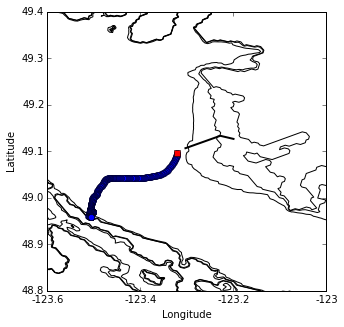

In [14]:
buoy = 1
name, tracks=organize_info(buoy,ubc)
print name
fig=plot_buoy(tracks,dt.datetime(2014,10,8),i=-1)

In [15]:
fig.savefig('drop212a.png')

UBC-I-0003
Released 2014-10-08 16:10:07.000003 at 49.1054983333 , -123.319833333 for 28.7502777783 hours
NEMO coords: 429 290


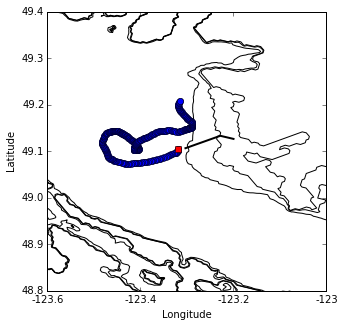

In [16]:
buoy = 2
name, tracks=organize_info(buoy,ubc)
print name
fig=plot_buoy(tracks,dt.datetime(2014,10,8), i=-1)

In [17]:
fig.savefig('drop112a.png')